In [5]:
import numpy as np

## Example: Susceptibility and Bose-Einstein condensation

Recall the density of an ideal gas:
$$
\tilde n (T,\tilde \mu) = \frac{d}{2\pi^2} \int_0^\infty d \tilde k \, \tilde k^2 \, \left[\exp\left\{\sqrt{\tilde{m}^2+\tilde k^2}-\tilde{\mu}\right\} + \eta \right ]^{-1}~,
$$
where $\tilde n \equiv n/T^3$, $\tilde m = m/T$, and $\tilde \mu = \mu / T$.


We previosuly learned to calculate this density using numerical integration.
The susceptibility is defined as a derivative of the density with respect to chemical potential
$$
\chi_2 = \frac{\partial \tilde{n} (\tilde T, \tilde{\mu})}{\partial \tilde \mu}.
$$

For a pion gas ($m = 138~\textrm{MeV}, d = 1, T = 150~\textrm{MeV}$),

1. Compute the susceptibility $\chi_2$ using finite differences at $\tilde{\mu} = 0$, for $\eta = 0$ and $\eta = -1$.
2. Compare the result for $\chi_2$ to the one obtained by numerically integrating the following expression
$$
\chi_2 = \frac{d}{2\pi^2} \int_0^\infty d \tilde k \, \tilde k^2 \, \frac{\exp\left\{\sqrt{\tilde{m}^2+\tilde k^2}-\tilde{\mu}\right\}} {\left[\exp\left\{\sqrt{\tilde{m}^2+\tilde k^2}-\tilde{\mu}\right\} + \eta \right ]^{2}},
$$
3. Compute the susceptibility as a function of $\tilde{\mu}$ in a range $\tilde{\mu} \in (0,\tilde{m})$. What is the behavior of $\chi_2$ as $\tilde{\mu}$ approaches the Bose condensation point, $\tilde{\mu} = \tilde{m}$?

## Solution

## Preliminaries

Import numerical integration routines and the density as a numerical integral



In [13]:
from IntegrateGauss import *
from NI_density_aux_GaussLaguerre import *
import NI_density_aux_GaussLaguerre
print(eta)

0


Test that it works as expected

In [14]:
NI_density_aux_GaussLaguerre.eta = -1
T = 150
mu = 0
NGL = 32

print("Testing NI_density_aux.py")
print("n/T^3 =", nT3num(T, mu, NGL))
# print("n/T^3 =", nT3numNrect(T, mu, 100))

Testing NI_density_aux.py
n/T^3 = 0.09332222578416971


## Step 1

We will use central difference

In [16]:
def chinumder(T, mu, dmu, NGL = 32):
    # mu - chemical potential
    # dmu - step size in dimensionless mu for numerical derivative
    # eps - accuracy goal for numerical integration
    
    # Central difference
    # chi ~ T * (nT3(mu + dmu) - nT3(mu - dmu)) / (2 * dmu)
    nplus = nT3num(T, mu + dmu, NGL)
    nminus = nT3num(T, mu - dmu, NGL)
    return T * (nplus - nminus) / (2 * dmu)

T = 150
mu = 0
m = 138
d = 1

NI_density_aux_GaussLaguerre.eta = 0
dmu = 1.e-4
print("Maxwell-Boltzmann chi2 =", chinumder(T, mu, dmu, NGL))
NI_density_aux_GaussLaguerre.eta = -1
print("    Bose-Einstein chi2 =", chinumder(T, mu, dmu, NGL))

Maxwell-Boltzmann chi2 = 0.08472249266727738
    Bose-Einstein chi2 = 0.10403956037310924


## Step 2

In [17]:
# Implement the evaluation of chi2 using numerical integration
def chiIntegral(T, mu, NGL = 32):
    # Nrect - number of subintervals for rectangle rule evaluating the integral
    # print("chiIntegral not implemented!")
    def chi2Integrand(k):
        return d / (2. * np.pi**2) * k**2 * np.exp(k) * np.exp(np.sqrt((m/T)**2+k**2)-mu/T) / (np.exp(np.sqrt((m/T)**2+k**2)-mu/T) + eta)**2
    
    quad = laguerrexw32
    if (NGL != 32):
        quad = laguerrexw(NGL)
    return integrate_quadrature(chi2Integrand, quad)

T = 150
mu = 0
eta = NI_density_aux_GaussLaguerre.eta = -1

print("    Bose-Einstein chi2 =", chiIntegral(T, mu, NGL))

    Bose-Einstein chi2 = 0.10403956033629298


## Step 3

In [18]:
# T = 150
# m = NI_density_aux.m = 138
muval = 137.9
eta = NI_density_aux_GaussLaguerre.eta = -1
dmu = 0.0001
print("Numerical derivative chi2 =", chinumder(T, muval, dmu, NGL))
mu = muval
print("            Analytic chi2 =", chiIntegral(T, muval, NGL))

Numerical derivative chi2 = 5.251540717413072
            Analytic chi2 = 5.251540163511


In [19]:
mus = np.arange(0., 138., 1.)
mus = np.arange(137., 138., 0.01)
# print(mus)
chi2sNder = []
chi2sNint = []

dmu = 0.0001

for mu in mus:
    chi2sNder.append(chinumder(T, mu, dmu, NGL))
    # chi2sNder.append(chinumderNrect(T, mu, dmu, Nrect))
    chi2sNint.append(chiIntegral(T, mu, NGL))

Numerical integration of $\chi_2$ is not very stable due to singular behavior of $\chi_2$ near $\mu = m$.

This can be mitigated by utilizing Gauss-Laguerre quadrature (try it!)

Let us plot the results

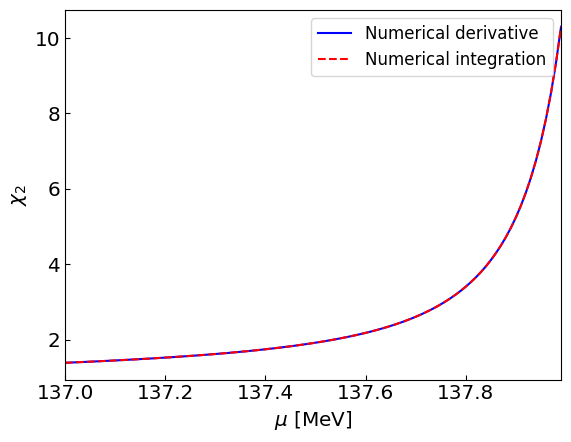

In [20]:
# Plot the results
import matplotlib.pyplot as plt

params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'xtick.direction':'in',
         'ytick.direction':'in',
         }
plt.rcParams.update(params)

plt.plot(mus, chi2sNder, label = "Numerical derivative", linestyle = '-', color = 'blue')
plt.plot(mus, chi2sNint, label = "Numerical integration", linestyle = '--', color = 'red')

plt.xlabel("${\mu}$ [MeV]")
plt.ylabel("${\\chi_2}$")
plt.xlim(mus[0],mus[-1])

plt.legend()

plt.show()

## BONUS: Using automatic differentiation

In [21]:
import mygrad as mg

def dfdx_mygrad(func, x):
    xx = mg.Tensor(x)
    y = func(xx)
    y.backward()
    return xx.grad

from mygrad import exp, sqrt

def fThermalMG(x):
    return d * x**2 * np.exp(x) / (2 * np.pi**2) / (exp(sqrt((m/T)**2 + x**2) - muAD/T) + eta)

def chi2AD(inT, inMu, NGL = 32):
    global T, mu
    T = inT
    mu = inMu
    quad = laguerrexw32
    if (NGL != 32):
        quad = laguerrexw(NGL)

    def fAD(x):
        global muAD
        muAD = x
        return integrate_quadrature(fThermalMG, quad)
    
    return T * dfdx_mygrad(fAD, mu)

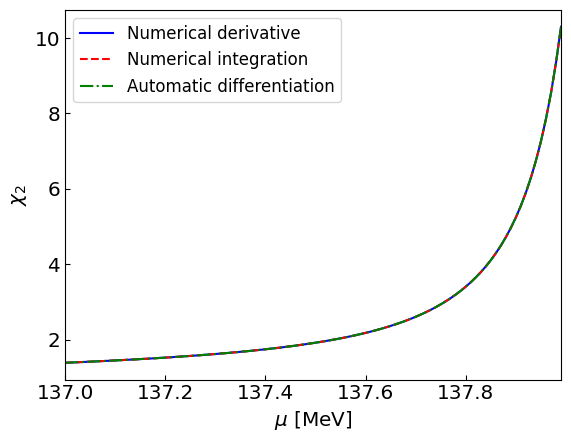

In [22]:
mus = np.arange(0., 138., 1.)
mus = np.arange(137., 138., 0.01)
# print(mus)
chi2sNder = []
chi2sNint = []
chi2sAD = []

dmu = 0.0001

for mu in mus:
    chi2sNder.append(chinumder(T, mu, dmu, NGL))
    chi2sNint.append(chiIntegral(T, mu, NGL))
    chi2sAD.append(chi2AD(T, mu, NGL))

plt.plot(mus, chi2sNder, label = "Numerical derivative", linestyle = '-', color = 'blue')
plt.plot(mus, chi2sNint, label = "Numerical integration", linestyle = '--', color = 'red')
plt.plot(mus, chi2sAD, label = "Automatic differentiation", linestyle = '-.', color = 'green')

plt.xlabel("${\mu}$ [MeV]")
plt.ylabel("${\\chi_2}$")
plt.xlim(mus[0],mus[-1])

plt.legend()

plt.show()